In [1]:
%load_ext autoreload
%autoreload 2

In [182]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import auc

from src.ensemble import get_de_preds, get_le_preds
from src.metrics import dice_coef, dice_norm_metric, soft_dice_norm_metric, rc_curve
from src.uncertainty import (entropy_of_expected_uncertainty, expected_entropy_uncertainty,
                             mutual_information_uncertainty, reverse_mutual_information_uncertainty,
                             expected_pw_kl_uncertainty, confidence_uncertainty,
                             max_softmax_uncertainty, max_confidence_uncertainty)

# Validation

In [97]:
le_validation_fpath = Path('models')/'LE_validation.npz'
de_validation_fpath = Path('models')/'DE_validation.npz'

le_preds, targets = get_le_preds(le_validation_fpath)
le_preds = le_preds['le_mean_starting_at_05']

de_preds, targets = get_de_preds(de_validation_fpath)
de_preds = de_preds['mean_ensemble']

le_ndsc_scores = list()
for pred, target in zip(le_preds, targets):
    le_ndsc_scores.append(dice_norm_metric(pred, target))
le_ndsc_scores = np.array(le_ndsc_scores)

de_ndsc_scores = list()
for pred, target in zip(de_preds, targets):
    de_ndsc_scores.append(dice_norm_metric(pred, target))
de_ndsc_scores = np.array(de_ndsc_scores)

In [173]:
def plot_auc_over_starting_layer(uncertainties, metrics,
                                 title='AUC over Starting Layer'):
    aucs = dict()
    for metric_name in metrics.keys():
        metric_aucs = list()
        unc_names = sorted([m for m in uncertainties.keys()
                            if m.startswith(metric_name)])
        for unc_name in unc_names:
            coverages, risks, _ = rc_curve(-uncertainties[unc_name],
                                           le_ndsc_scores, expert=False)
            metric_aucs.append(auc(coverages, risks))

        plt.plot(metric_aucs,
                 label=f"{metric_name} ({min(metric_aucs):.3f}@{np.argmin(metric_aucs)})")

        aucs[metric_name] = metric_aucs

    coverages, risks, _ = rc_curve(le_ndsc_scores, le_ndsc_scores, expert=False)
    ideal_auc = auc(coverages, risks)
    plt.hlines(ideal_auc, 0, 10, linestyle='--', label=f'ideal ({ideal_auc:.3f})')

    plt.title(title)
    plt.ylabel('AUC of Risk-Coverage (no expert)')
    plt.xlabel('starting layer')
    plt.legend()
    plt.grid()

    return aucs

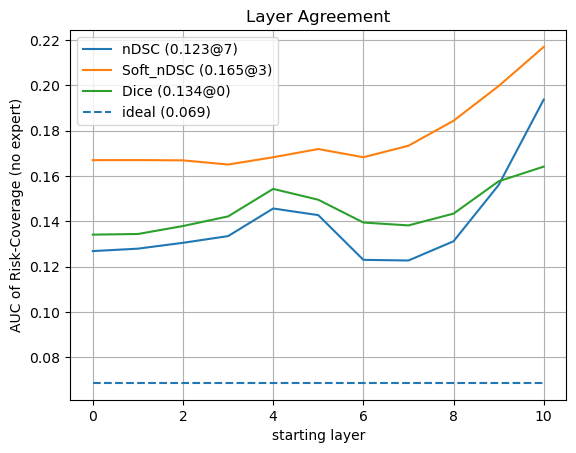

In [174]:
def apply_layer_agreement_metric(Y_hat, metric):
    uncertainties = list()
    for y_hat in Y_hat.swapaxes(0,1):
        uncertainty = [metric(y_hat[i], y_hat[i+1])
                       for i in range(y_hat.shape[0]-1)]
        uncertainties.append(sum(uncertainty) / len(uncertainty))
    
    return np.array(uncertainties)

agreement_metrics = {'nDSC': lambda *args: -dice_norm_metric(*args),
                     'Soft_nDSC': lambda *args: -soft_dice_norm_metric(*args),
                     'Dice': lambda *args: -dice_coef(*args),}

layer_agreement_uncertainties = dict()
with np.load(le_validation_fpath) as data:
    Y_hat = data['y_hat']
    targets = data['y']

    for i in range(Y_hat.shape[0]-1):
        components = Y_hat[i:]
        for metric_name, metric in agreement_metrics.items():
            layer_agreement_uncertainties[metric_name+f'@le_from_{i:02d}'] = (
                apply_layer_agreement_metric(components, metric)
            )

plot_auc_over_starting_layer(layer_agreement_uncertainties, agreement_metrics,
                             title='Layer Agreement')
plt.show()

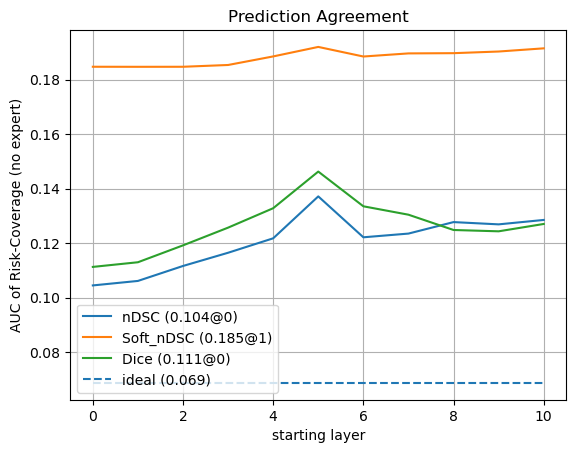

In [175]:
def apply_pred_agreement_metric(Y_hat, preds, metric):
    uncertainties = list()
    for y_hat, pred in zip(Y_hat.swapaxes(0,1), preds):
        uncertainty = [metric(y_hat[i], pred) for i in range(y_hat.shape[0]-1)]
        uncertainties.append(sum(uncertainty) / len(uncertainty))
    return np.array(uncertainties)

agreement_metrics = {'nDSC': lambda *args: -dice_norm_metric(*args),
                     'Soft_nDSC': lambda *args: -soft_dice_norm_metric(*args),
                     'Dice': lambda *args: -dice_coef(*args),}

pred_agreement_uncertainties = dict()
with np.load(le_validation_fpath) as data:
    Y_hat = data['y_hat']
    targets = data['y']

    for i in range(Y_hat.shape[0]-1):
        components = Y_hat[i:]
        for metric_name, metric in agreement_metrics.items():
            pred_agreement_uncertainties[metric_name+f'@le_from_{i:02d}'] = (
                apply_pred_agreement_metric(components, le_preds, metric)
            )

plot_auc_over_starting_layer(pred_agreement_uncertainties, agreement_metrics,
                             title='Prediction Agreement')
plt.show()

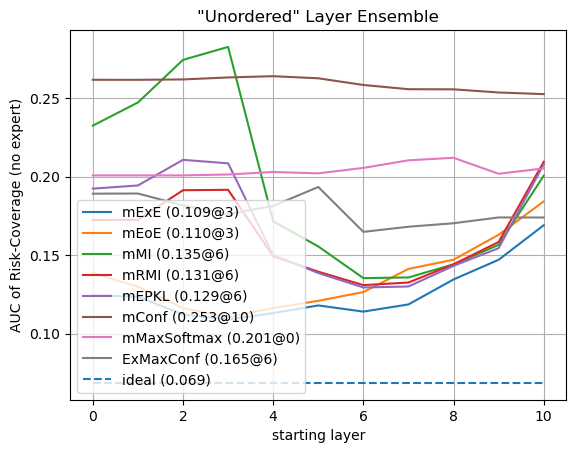

In [180]:
def apply_ensemble_metric(Y_hat, metric):
    uncertainties = list()
    for y_hat in Y_hat.swapaxes(0,1):
        uncertainties.append(metric(y_hat))
    
    return np.array(uncertainties)

ensemble_metrics = {'mExE': expected_entropy_uncertainty,
                    'mEoE': entropy_of_expected_uncertainty,
                    'mMI': mutual_information_uncertainty,
                    'mRMI': reverse_mutual_information_uncertainty,
                    'mEPKL': expected_pw_kl_uncertainty,
                    'mConf': confidence_uncertainty,
                    # 'MaxExConf': max_expected_confidence,
                    'mMaxSoftmax': max_softmax_uncertainty,
                    # 'MaxMeanSoftmax': max_mean_softmax,
                    'ExMaxConf': max_confidence_uncertainty,}

le_ensemble_uncertainties = dict()
with np.load(le_validation_fpath) as data:
    Y_hat = data['y_hat']
    targets = data['y']

    for i in range(Y_hat.shape[0]-1):
        components = Y_hat[i:]
        for metric_name, metric in ensemble_metrics.items():
            le_ensemble_uncertainties[metric_name+f'@le_from_{i:02d}'] = (
                apply_ensemble_metric(components, metric)
            )

plot_auc_over_starting_layer(le_ensemble_uncertainties, ensemble_metrics,
                             title='"Unordered" Layer Ensemble')
plt.show()

In [185]:
def apply_ensemble_metric(Y_hat, metric):
    uncertainties = list()
    for y_hat in Y_hat.swapaxes(0,1):
        uncertainties.append(metric(y_hat))
    
    return np.array(uncertainties)

ensemble_metrics = {'mExE': expected_entropy_uncertainty,
                    'mEoE': entropy_of_expected_uncertainty,
                    'mMI': mutual_information_uncertainty,
                    'mRMI': reverse_mutual_information_uncertainty,
                    'mEPKL': expected_pw_kl_uncertainty,
                    'mConf': confidence_uncertainty,
                    # 'MaxExConf': max_expected_confidence,
                    'mMaxSoftmax': max_softmax_uncertainty,
                    # 'MaxMeanSoftmax': max_mean_softmax,
                    'ExMaxConf': max_confidence_uncertainty,}

de_uncertainties = dict()
de_aucs = dict()
with np.load(de_validation_fpath) as data:
    Y_hat = data['y_hat']
    targets = data['y']

    for metric_name, metric in ensemble_metrics.items():
        uncertainties = apply_ensemble_metric(Y_hat, metric)
        de_uncertainties[metric_name] = uncertainties

        coverages, risks, _ = rc_curve(-uncertainties, de_ndsc_scores,
                                       expert=False)
        de_aucs[metric_name] = auc(coverages, risks)

    coverages, risks, _ = rc_curve(de_ndsc_scores, de_ndsc_scores,
                                   expert=False)
    de_aucs['ideal'] = auc(coverages, risks)

pd.Series(de_aucs).sort_values()

ideal          0.062648
ExMaxConf      0.143202
mEoE           0.178708
mMaxSoftmax    0.189774
mExE           0.202213
mConf          0.244632
mRMI           0.429250
mEPKL          0.434715
mMI            0.437412
dtype: float64